### Correction of Topological Errors in Traces 
Multiple stacks of neuron images were traced by two users to create a labeled dataset and assess the baseline of inter-user variability. All traces were then disconnected at branch points and a deep neural network was trained to detect the correct way of reconnecting the branches. Custom morphological features were generated for each cluster of branch points, in a way that is dependent on a merging scenario but invariant to translations, rotations, and reflections of the cluster in the imaging plane. The features and image volume centered at the branch point were used for training a neural network that concatenates these input streams and outputs the confidence measure for different branch merging scenarios.


In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import seed
from keras.constraints import maxnorm
import seaborn as sns
import scipy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras
from keras.layers import (Concatenate, Conv3D, Dropout, Input, BatchNormalization, Flatten,
                          Dense, MaxPooling3D, UpSampling3D, Activation, Reshape, Lambda,
                           Permute)
from keras.callbacks import TensorBoard
import datetime
import scipy.io as sio
import AT_Classes as Classes

In [74]:
def convolutionblock(x, name, fms, params):
    x = Conv3D(filters=fms, **params, name=name+"_conv0")(x)
    x = BatchNormalization(name=name+"_bn0")(x)
    x = Activation("relu", name=name+"_relu0")(x)

    x = Conv3D(filters=fms, **params, name=name+"_conv1")(x)
    x = BatchNormalization(name=name+"_bn1")(x)
    x = Activation("relu", name=name)(x)
    return x

In [75]:
lst_useImage = ['True']             # Using the second tower or not, Default = ['True','False']
useEndpointFeatures = 'True'        # Use the proposed endpoint features
kernel_initializer='he_uniform'     # Kernel Initializer, Methods: HeNormal, Identity, LecunUniform, LecunNormal
rotation_degrees = [0,90,180,270]
flips = ['right']
UseConv = True
maxNumPoints = 12                   # Limit the maximum number of merging points

root_dir = 'E:/AutomatedTracing/TraceProofreading/TraceProofreading'

rotated_IMs = np.zeros([13,13,13,len(rotation_degrees)])

In [76]:
ImagetoTest = 1
UseIMage = ['True']
run = 0
epoch  = 10             # number of epochs
batch_size = 50         # batch size, Defualt = 50
verbose= 1              # verbose=1 will show you an animated progress bar
doSMOTE = False         # Replicate data using SMOTE method
learning_Rate = 0.001   # Learning Rate, # Default  =0.001

# Define now time for unique names in the model
T = datetime.datetime.today()
nowTimeDate = T.strftime("%b_%d_%H_%M")
# PltNAme = 'AT_XYZ_is5_'+str(useXYZ_Positions)+'_'+str(ImagetoTest)+'_run=2'+nowTimeDate

PltNAme = 'TEMP22_Drop_20_3LAyerHalf81616_kernel555_S1_2_SmUnet1TEST20INV_FEATURES_CONV=' + str(UseConv) + '_LR=' + str(learning_Rate) + '_100_sce_' + str(
    kernel_initializer) + '_IM=' + str(ImagetoTest) + 'bchSiz=' + str(batch_size) + '_Use_IM=' + str(
    UseIMage) + '_Epoch=' + str(
    epoch) + '_run=' + str(run + 1) + '_' +nowTimeDate
print(PltNAme)

TEMP22_Drop_20_3LAyerHalf81616_kernel555_S1_2_SmUnet1TEST20INV_FEATURES_CONV=True_LR=0.001_100_sce_he_uniform_IM=1bchSiz=50_Use_IM=['True']_Epoch=10_run=1_Feb_28_10_10


In [77]:
 # Use this for combination of Datasets 1 and 2
filepath = \
    'E:\AutomatedTraceResults\DataForConnectingTraining\Data_For_AE_BranchScenarios\S1and2_IMonce_100_scen_NEW_Inv_FEATURES_User=SK.mat'

# Load scienaros information
ScenariosData = sio.loadmat(filepath)

In [78]:
# Get Image numbers
IMnums = ScenariosData['IMnum']
# IMnum = IMnums[0,IMnums.shape[1]-1]
# IMnums.shape

# Get Features
Features = ScenariosData['NewFeatures']
# Feature = Features[0,Features.shape[1]-1]
# Feature.shape

# Get Image Intensities Data
IMs = ScenariosData['IMs']
# IMtmp = IMs[0,IMs.shape[1]-1]
# IMtmp.shape

# Get Scenarios Information
Scenarios = ScenariosData['Scenarios']
# Scenarios.shape
# Scenarios[0,Scenarios.shape[1]-1]

# Get Labels for Training
Labels = ScenariosData['Labels']
# Labels[0,Labels.shape[1]-1]

# Clear Data for Each Run

IMsTrain = []
FeatureTrain = []
LabelsTrain = []
ScenariosTrain = []
IMsTest = []
FeatureTest = []
LabelsTest = []
ScenariosTest = []
# Use Uper triangle in matrix,
# the scienario matrix is symmetric matrix but you may use all data
UseUpper = False
numScenarios = Scenarios.shape
counter = 0

#### Generating Scienaros and Feature Data

In [79]:
for i in range(numScenarios[1]):
    scenario = Scenarios[0,i]

    IM = IMs[0,i]
    # print(IM.shape)
    Feature = Features[0, i]

    # if scenario.shape[0] == 3:
    #     maxNumPoints = 3

    for r in range(len(rotation_degrees)):
        degree = rotation_degrees[r]
        print(degree)
        rotated_IMs[:,:,:,r] = scipy.ndimage.interpolation.rotate(IM, degree, mode='nearest', reshape=False)
        # IM_Proj = Classes.IM3D.Z_Projection(rotated_IMs[:,:,:,r])
        # Classes.IM3D.plt(IM_Proj)

    Label = Labels[0, i]
    # print(scenarios.shape)
    # if scenario.any():
    # scenarios.shape[2]

    # Geting Scenario data from matrix (upper or all)
    S = Classes.cl_scenario(maxNumPoints, scenario.shape[0],scenario,0)
    if UseUpper:
        scenario_arr = S.getUpperArr()
    else:
        scenario_arr = S.getWholeArr()

    # Exclude the Test Image in Training
    # Generating Training and Test Data
    if IMnums[0, i] != ImagetoTest:
        ScenariosTrain.append(scenario_arr)
        IMsTrain.append(IM)
        FeatureTrain.append(Feature)
        LabelsTrain.append(Label)
    else:
        ScenariosTest.append(scenario_arr)
        IMsTest.append(IM)
        FeatureTest.append(Feature)
        LabelsTest.append(Label)

In [80]:
# Numpy array creation
ScenariosTrain = np.asarray(ScenariosTrain, dtype=np.float)
IMsTrain = np.asarray(IMsTrain, dtype=np.float)
IMsTrain3D = IMsTrain
FeatureTrain = np.asarray(FeatureTrain, dtype=np.float)
FeatureTrain = FeatureTrain[:,0,:]
LabelsTrain = np.asarray(LabelsTrain, dtype=np.float)
LabelsTrain = LabelsTrain[:,0]
LabelsTrain = LabelsTrain[:,0]
IMTrain = np.reshape(IMsTrain, [IMsTrain.shape[0],np.product(IMsTrain[0,:,:,:].shape)])


#### Shuffling Data

In [81]:

indices = np.arange(len(ScenariosTrain))
np.random.shuffle(indices)
ScenariosTrain = ScenariosTrain[indices]
IMsTrain = IMsTrain[indices]
FeatureTrain = FeatureTrain[indices]

LabelsTrain = LabelsTrain[indices]

print(IMTrain.shape)
print(FeatureTrain.shape)
print(ScenariosTrain.shape)
print(LabelsTrain.shape)

# Plot data count
# z_train = Counter(yIMs_train)
# sns.countplot(yIMs_train)

(11684, 2197)
(11684, 108)
(11684, 144)
(11684,)


In [82]:
# to ignore image data
if UseIMage == False:
    IMTrain = np.zeros(IMTrain.shape)
    IMsTest = np.zeros(IMsTest.shape)
    print('Not Using Image')

#### Convolutional for first tower

In [83]:

if UseConv:
    # input1 = Input(shape=(13, 13, 13, 1))
    # x = Conv3D(32, (3, 3, 3), padding='same', activation='relu')(
    #     input1)  # change to leakyRelu to avoid dead neurons
    # x = Conv3D(64, (3, 3, 3), padding='same', activation='relu')(x)
    # x = MaxPooling3D((2, 2, 2))(x)
    # x2 = Flatten()(x)

    # fms = 8 # or more if no improve
    input1 = Input(shape=(13, 13, 13, 1), name="inputs")

    params = dict(kernel_size=(5, 5, 5), activation=None,
                  padding="same", kernel_initializer="he_uniform")

    # Transposed convolution parameters
    # params_trans = dict(kernel_size=(2, 2, 2), strides=(1, 1, 1), padding="same")

    # BEGIN - Encoding path
    # encodeA = ConvolutionBlock(input1, "encodeA", fms, params)

    # First Encoder
    name = "encodeA"
    x = Conv3D(filters=8, **params, name=name + "_conv0")(input1)
    x = BatchNormalization(name=name + "_bn0")(x)
    x = Dropout(.20)(x)
    x = Activation("relu", name=name + "_relu0")(x)
    # x = Conv3D(filters=4, **params, name=name + "_conv1")(x)
    # x = BatchNormalization(name=name + "_bn1")(x)
    # encodeA = Activation("relu", name=name)(x)
    poolA = MaxPooling3D(name="poolA", pool_size=(2, 2, 2))(x)

    # Second Encoder
    name = "encodeB"
    x = Conv3D(filters=16, **params, name=name + "_conv0")(poolA)
    x = BatchNormalization(name=name + "_bn0")(x)
    x = Dropout(.20)(x)
    x = Activation("relu", name=name + "_relu0")(x)
    # x = Conv3D(filters=8, **params, name=name + "_conv1")(x)
    # x = BatchNormalization(name=name + "_bn1")(x)
    # encodeB = Activation("relu", name=name)(x)
    poolB = MaxPooling3D(name="poolB", pool_size=(2, 2, 2))(x)

    # Third Encoder
    name = "encodeC"
    x = Conv3D(filters=16, **params, name=name + "_conv0")(poolB)
    x = BatchNormalization(name=name + "_bn0")(x)
    x = Activation("relu", name=name + "_relu0")(x)
    # # x = Conv3D(filters=16, **params, name=name + "_conv1")(x)
    # # x = BatchNormalization(name=name + "_bn1")(x)
    # # encodeC = Activation("relu", name=name)(x)
    # poolC = MaxPooling3D(name="poolC", pool_size=(2, 2, 2))(x)

    # # Fourth Encoder
    # name = "encodeD"
    # x = Conv3D(filters=32, **params, name=name + "_conv0")(poolC)
    # x = BatchNormalization(name=name + "_bn0")(x)
    # x = Activation("relu", name=name + "_relu0")(x)
    # # x = Conv3D(filters=32, **params, name=name + "_conv1")(x)
    # # x = BatchNormalization(name=name + "_bn1")(x)
    # # encodeC = Activation("relu", name=name)(x)
    x2 = Flatten()(x) #was PoolA
else:
    # # Relu
    input1 = keras.layers.Input(shape=(IMTrain.shape[1],))
    # ,kernel_regularizer=keras.regularizers.l2(l=0.2)
    x1 = keras.layers.Dense(32, input_dim=IMTrain.shape[1], activation='relu')(input1)
    x2 = keras.layers.Dense(16, input_dim=IMTrain.shape[1], activation='relu')(x1)

#### Handcrafted Features for Second Tower

In [84]:

input3 = keras.layers.Input(shape=(FeatureTrain.shape[1],))
xxx0 = keras.layers.Dense(32, input_dim=FeatureTrain.shape[1], activation='relu')(input3)
xxx1 = keras.layers.Dense(16, input_dim=FeatureTrain.shape[1], activation='relu')(xxx0)
# xxx2 = keras.layers.Dense(8, input_dim=XFeature_train.shape[1], activation='relu')(xxx1)
# xxx2 = keras.layers.Dense(16, activation='relu')(xxx1)
# xxx3 = keras.layers.Dense(8, activation='relu')(xxx2)

# Combine Towers
combined = keras.layers.concatenate([x2, xxx1])
# Relu
out = keras.layers.Dense(4, activation='sigmoid')(combined)
# Leaky Relu
# out = keras.layers.Dense(4)(added)
# out = keras.layers.LeakyReLU(alpha=0.05)(out)

#### Final output

In [85]:
out1 = keras.layers.Dense(1, activation='sigmoid')(out)
model = keras.models.Model(inputs=[input1, input3], outputs=out1)

#### Customized Loss functions

In [86]:
import keras.backend as K

def CrossEntropy(y_true,y_pred):
    if y_true == 1:
        return -log(y_pred)
    else:
        return -log(1 - y_pred)

def keras_loss_0(y_true,y_pred):
        return K.mean(K.square(y_pred - y_true) + K.square(layer), axis=-1)

def keras_loss_1(y_actual, y_predicted):
    loss_value = K.mean(K.sum(K.square((y_actual-y_predicted)/0.5)))
    return loss_value

def mean_squared_logarithmic_error(y_true, y_pred):
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.mean(K.square(first_log - second_log), axis=-1)

#### Compile model


In [88]:
optimizer = keras.optimizers.Adam(lr=learning_Rate)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'],

              )
# Tensor board Data
tensorboard = TensorBoard(log_dir="E:/AutomatedTracing/AutomatedTracing/Python/logs/"+PltNAme)

# checkpoint # This is Called Early Stopping (stop at best validation)
from keras.callbacks import ModelCheckpoint
filepath= root_dir + '/data/models/'+PltNAme+"_weights.max_val_acc.hdf5"
checkpoint_max_val_acc = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

filepath = root_dir + '/data/models/'+ PltNAme + "_weights.min_val_acc.hdf5"
checkpoint_min_val_acc = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True,
                                         mode='min')
            

In [90]:
filepath = root_dir + '/data/models/'+ PltNAme + "_weights.max_val_loss.hdf5"
checkpoint_max_val_loss = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')

filepath = root_dir + '/data/models/'+ PltNAme + "_weights.min_val_loss.hdf5"
checkpoint_min_val_loss = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True,
                                          mode='min')

In [91]:
if UseConv:
    X_IMs = IMsTrain3D.reshape(IMsTrain3D.shape[0], IMsTrain3D.shape[1],
                               IMsTrain3D.shape[2], IMsTrain3D.shape[3],1)
else:
    X_IMs = IMTrain

#### Model fit

In [92]:

history = model.fit([X_IMs,FeatureTrain],
                    LabelsTrain,
                    epochs=epoch,
                    batch_size=batch_size,
                    validation_split=0.30,
                    verbose=1
#                     ,callbacks=[checkpoint_max_val_acc,checkpoint_min_val_acc,checkpoint_max_val_loss,checkpoint_min_val_loss,tensorboard],
                    )

Train on 8178 samples, validate on 3506 samples
Epoch 1/10
8178/8178 [==============================] - 10s 1ms/step - loss: 0.6298 - accuracy: 0.9128 - val_loss: 0.5670 - val_accuracy: 0.9353
Epoch 2/10
8178/8178 [==============================] - 8s 995us/step - loss: 0.5196 - accuracy: 0.9335 - val_loss: 0.4754 - val_accuracy: 0.9353
Epoch 3/10
8178/8178 [==============================] - 8s 998us/step - loss: 0.4422 - accuracy: 0.9335 - val_loss: 0.4095 - val_accuracy: 0.9353
Epoch 4/10
8178/8178 [==============================] - 8s 1ms/step - loss: 0.3864 - accuracy: 0.9335 - val_loss: 0.3621 - val_accuracy: 0.9353
Epoch 5/10
8178/8178 [==============================] - 8s 986us/step - loss: 0.3463 - accuracy: 0.9335 - val_loss: 0.3280 - val_accuracy: 0.9353
Epoch 6/10
8178/8178 [==============================] - 8s 999us/step - loss: 0.3175 - accuracy: 0.9335 - val_loss: 0.3034 - val_accuracy: 0.9353
Epoch 7/10
8178/8178 [==============================] - 8s 989us/step - loss: 0

In [69]:
# Save Model
model.save(root_dir + '/data/models/'+ PltNAme+'.h5')

In [70]:
# Model Summary
print(model.summary())
from keras.utils.vis_utils import plot_model
# pltName = root_dir + '/data/models/'+PltNAme+'.png'
# print(pltName)
plot_model(model, to_file=pltName, show_shapes=True, show_layer_names=True)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 13, 13, 13, 1 0                                            
__________________________________________________________________________________________________
encodeA_conv0 (Conv3D)          (None, 13, 13, 13, 8 1008        inputs[0][0]                     
__________________________________________________________________________________________________
encodeA_bn0 (BatchNormalization (None, 13, 13, 13, 8 32          encodeA_conv0[0][0]              
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 13, 13, 13, 8 0           encodeA_bn0[0][0]                
____________________________________________________________________________________________

OSError: `pydot` failed to call GraphViz.Please install GraphViz (https://www.graphviz.org/) and ensure that its executables are in the $PATH.

### Plot training & validation loss

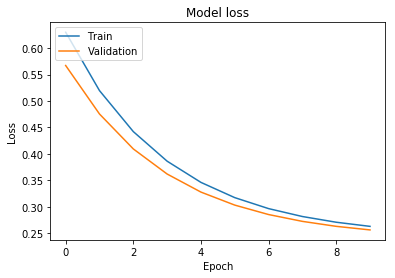

E:/AutomatedTracing/TraceProofreading/TraceProofreading/data/models/TEMP22_Drop_20_3LAyerHalf81616_kernel555_S1_2_SmUnet1TEST20INV_FEATURES_CONV=True_LR=0.001_100_sce_he_uniform_IM=1bchSiz=50_Use_IM=['True']_Epoch=10_run=1_Feb_28_10_10_loss.png


<Figure size 432x288 with 0 Axes>

In [94]:

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
fig=plt.show()
pltLoss = root_dir + '/data/models/'+PltNAme+'_loss.png'
plt.savefig(pltLoss)
print(pltLoss)

### Customized Activation function

In [ ]:
# Creating a model
from keras.models import Sequential
from keras.layers import Dense

# Custom activation function
from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects


def custom_activation(x):
    return (K.sigmoid(x) * 5) - 1

get_custom_objects().update({'custom_activation': Activation(custom_activation)})

# Usage
model = Sequential()
model.add(Dense(32, input_dim=784))
model.add(Activation(custom_activation, name='SpecialActivation'))
print(model.summary())